In [1]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import os
import imageio
import ffmpeg
import time
import pandas as pd
# from cellpose import io, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
import torch.nn.functional as F
from utils import *
cudnn.benchmark = True
from VideoLoaders import *
plt.ion()   # interactive mode

In [2]:
class VideoDataMIP:
    def __init__(self, files):
        self.data = {
        }
        
        for category, num in files:
            print(f"Loading in MIP {num}")
            print(category)
            # assert category == 'mip', "Can't load non Mip file"
            file = {}
            file['video'] = get_file(category, num)
            
            frames, shp = file['video'].read_image(C=0)
            frames = scale_img(frames.squeeze())
            file['frames'] = frames
            print(f"frames {num}: {frames.shape}")
            file['masks'] = binarize_video(frames)           
    
            self.data[num] = file    
    def extract_all_traces(self, file_num, sequence_length, hist_length=2):
        # hist length is how many frames of history
        frames, masks = self.data[file_num]['frames'], self.data[file_num]['masks']
        N = len(frames)
        s = 0
        all_traces = []
        all_videos = []
        for i in range(N // sequence_length):
            print(f"Extracting traces from {s}:{s+sequence_length}")
            data, videos = extract_traces(frames[s:s+sequence_length], masks[s:s+sequence_length], hist=hist_length)
            s += sequence_length
            all_traces = all_traces + data
            all_videos = all_videos + videos
        
        if(N % sequence_length > 0):
            data, videos = extract_traces(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
            all_traces = all_traces + data
            all_videos = all_videos + videos        
        self.data[file_num]['traces'] = all_traces
        self.data[file_num]['trace_videos'] = all_videos
            

In [3]:
from skimage.measure import centroid
import skimage.measure as skm

max_padding =  300

box_shape = (180, 180) #TO DO: find the biggest box and set it to this
X = 10

class CellBoxMaskPatch(torch.utils.data.Dataset):
    #input will be a Directory name, function is TO DO
    def __init__(
        self,
        files, 
        X=X):
        
        self.mips_extractor = VideoDataMIP(files)
        # self.proc_extractor = VideoDataProcessed(files)

        for i in files:
            self.mips_extractor.extract_all_traces(i[1], X)
        
        
        self.cell_dict = []

        for key in self.mips_extractor.data:
            entry = self.mips_extractor.data[key]["traces"]
            for cell in entry:
                patches = [np.array(p) for p in cell["patches"]]
                boxes = [np.array(b) for b in cell['boxes']]
                masks = [np.array(m) for m in cell['masks']]
                
                self.cell_dict.append((boxes, masks, patches)) #cell dict is a list of 3 types by sequence

        self.num_cells = len(self.cell_dict) #this is a list of how many sequences we have
              
    def __len__(self):
        return self.num_cells
        

    def get_centroids(self, boxes, masks):
        N = len(masks)
        res = []
        centroids = [skm.centroid(binary.astype(np.uint8)) for binary in masks]
        for i in range(N):
            c = centroids[i]
            ymin, xmin = boxes[i][:2]
            res.append([xmin+c[0], ymin+c[1]])
        return(np.array(res) - res[0]) 
   
    def pad_arrays(self, array, pad_amt=max_padding):
    
        pad_width = ((0, pad_amt - array.shape[0]), (0, pad_amt - array.shape[1]))

        padded_array = np.pad(array, pad_width, mode='constant')
        return padded_array

    def __getitem__(self, idx):
        cell_sequences = self.cell_dict[idx]  #this is the first sequence of 10 cells
        boxes = cell_sequences[0]
        masks = cell_sequences[1]
        patches = cell_sequences[2]


        for cell_mask_num in np.arange(len(masks)): #should be sequence length (10) masks
                
                cell_time = np.array(masks[cell_mask_num], dtype=np.int32)
                cell_time = np.where(cell_time >= 0, cell_time, 1)
                cell_time = self.pad_arrays(cell_time)
                masks[cell_mask_num] = cell_time
                cell_time_patch = np.array(patches[cell_mask_num], dtype=np.int32)

                cell_time_patch = self.pad_arrays(cell_time_patch)

                patches[cell_mask_num] = cell_time_patch


        centroids = self.get_centroids(boxes, masks)
    

        return centroids, masks, patches

In [4]:
from torch.utils.data import random_split

mip_video_files = [
    ('mip', 3),
    ('mip', 6),
    ('mip', 9)
]

dataset = CellBoxMaskPatch(mip_video_files, X) # file, S, T

train, eval, test = random_split(dataset, [0.7, 0.2, 0.1])

input_datasets = {}
input_datasets["train"] = train
input_datasets["eval"] = eval
input_datasets["test"] = test

Loading in MIP 3
mip
Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]
frames 3: (90, 2048, 474)
Loading in MIP 6
mip
Loading dicty_factin_pip3-06_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 6: (241, 2048, 474)
Loading in MIP 9
mip
Loading dicty_factin_pip3-09_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 241)}]
frames 9: (241, 2048, 474)
Extracting traces from 0:10
Extracting traces from 10:20
Extracting traces from 20:30
Extracting traces from 30:40
Extracting traces from 40:50
Extracting traces from 50:60
Extracting traces from 60:70
Extracting traces from 70:80
Extracting traces from 80:90
Extracting traces from 0:10
Extracting traces from 10:20
Extracting traces from 20:30
Extracting traces from 30:40
Extracting traces from 40:50
Extracting traces from 50:60
Extracting traces from 60:70
Extracting traces from 70:80
Extracting traces from 80:90
Extracting 

In [5]:
def collate_fn(batch, mode_box, mode_mask, mode_patch):
    label = 0
    current_centroids = [b[0] for b in batch]
    current_masks = [b[1] for b in batch]
    current_patches = [b[2] for b in batch]

    current_centroids = torch.tensor(np.stack(current_centroids), dtype=torch.float32)
    current_masks = torch.tensor(np.stack(current_masks), dtype=torch.long)
    current_patches = torch.tensor(np.stack(current_patches), dtype=torch.long)

    current_patches = current_patches.reshape([len(batch), 1, 10, max_padding, max_padding])
    current_masks = current_masks.reshape([len(batch), 1, 10, max_padding, max_padding])

    return current_masks, current_patches


In [6]:
# box is actually a box surrounding the cell
# mask is the values of the cell
# patch is fluorescence
mode_box = True
mode_mask = True
mode_patch = False

input_size = 0
if mode_box:
    input_size+=2
if mode_mask:
    input_size+=max_padding*max_padding
if mode_patch:
    input_size+=max_padding*max_padding

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(
    input_datasets['train'],
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn(batch, mode_box, mode_mask, mode_patch)
)

dataloaders['test'] = torch.utils.data.DataLoader(
    input_datasets['test'],
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn(batch, mode_box, mode_mask, mode_patch)
)

dataloaders['eval'] = torch.utils.data.DataLoader(
    input_datasets['eval'],
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn(batch, mode_box, mode_mask, mode_patch)
)

In [7]:
for batch in dataloaders['eval']:
    print("Masks:", batch[0].shape, "Patches", batch[1].shape)
    break
    
#was Input: torch.Size([3, 10, 90000]) Centroids torch.Size([3, 10, 2])


Masks: torch.Size([4, 1, 10, 300, 300]) Patches torch.Size([4, 1, 10, 300, 300])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cpu')

In [13]:
import torch.nn.functional as F

class Conv_3d_CNN(nn.Module):
    def __init__(self):
        super(Conv_3d_CNN, self).__init__()
        self.conv3d = nn.Conv3d(1, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv3d(x.float())
        # print(x.shape)
        return x

In [10]:

class Comp_3d_CNN(nn.Module):
    def __init__(self):
        super(Comp_3d_CNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv3d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x.float())
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        return x

In [11]:
import torch.nn.functional as F

class Conv_3d_CNNlSTM(nn.Module):
    def __init__(self):
        super(Conv_3d_CNNlSTM, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)
        self.lstm = nn.LSTM(64 * 75 * 75 *2, 128, batch_first=True)
        

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x.float())))  # Convert input to float
        # print("1", x.shape)
        x = self.pool(torch.relu(self.conv2(x)))
        # print("2", x.shape)
        x = x.view(-1, 64 * 75 * 75 *2)  # Reshape before fully connected layer
        # print("3", x.shape)
        x, __ = self.lstm(x)
        # print("4", x.shape)
        x = torch.relu(self.fc1(x))
        # print("5", x.shape)
        x = self.fc2(x)
        # print("6", x.shape)

        return x

In [18]:
input_size = 2
hidden_size = 2000
num_layers = 2
epochs = 50
sequence_length = 10 #how many frames we process per input

train_loss = []
val_loss = []

# model = LSTM(input_size, hidden_size, num_layers)
model = Conv_3d_CNN()
if torch.cuda.is_available():
    model = model.cuda()

# dummy_input_data = torch.randn(batch_size, 10, input_size)

input_type = 'patch'
output_type = 'patch'

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def train():
    model.train()
    total_loss = 0
    total_correct = 0
    for batch in dataloaders['train']:
        optimizer.zero_grad()
        masks, patches = batch[0], batch[1]

        if input_type == "mask":
            inputs = masks
        else:
            inputs = patches

        if output_type == "masks":
            outputs = masks
        else:
            outputs = patches
     
        inputs, outputs = inputs.to(device), outputs.to(device)
        pred = model(inputs[:, :sequence_length-1, :])
      
        loss = criterion(pred.squeeze(), outputs[:,-1,:].float())*1000
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"training loss: {total_loss / len(dataloaders['train'])}")
    return model

def eval():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloaders['eval']:
            masks, patches = batch[0], batch[1]
            if input_type == "mask":
                inputs = masks
            else:
                inputs = patches

            if output_type == "masks":
                outputs = masks
            else:
                outputs = patches


            inputs, outputs = inputs.to(device), outputs.to(device)
            pred = model(inputs[:, :sequence_length-1, :]).squeeze()
 
            loss = criterion(pred, outputs[:,-1,:])*1000
            total_loss += loss.item()
    print(f"validation loss: {total_loss / len(dataloaders['eval'])}")
    return total_loss / len(dataloaders['eval'])


def train_model():
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print("Epoch:", epoch)
        loss_t = train()
        train_loss.append(loss_t)
        loss_e = curr_acc = eval()
        val_loss.append(loss_e)
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    y1 = train_loss
    y2 = val_loss

    plt.plot(range(len(y1)), y1, color='blue', label='Train Loss')
    plt.plot(range(len(y2)), y2, color='red', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(best_model_wts)


    return model

In [19]:
final = train_model()

Epoch: 0
training loss: 0.6544098649706159
validation loss: 0.00628158455947414
Epoch: 1
training loss: 0.632316022685596
validation loss: 0.00605591838248074
Epoch: 2
training loss: 0.6105260189090457
validation loss: 0.00584374888567254
Epoch: 3
training loss: 0.5888576124395642
validation loss: 0.0056372699327766895
Epoch: 4
training loss: 0.5681618720293045
validation loss: 0.005437640438321978
Epoch: 5
training loss: 0.5480430226240839
validation loss: 0.005240967031568289
Epoch: 6
training loss: 0.528485925921372
validation loss: 0.0050555677036754785
Epoch: 7
training loss: 0.5094865632908685
validation loss: 0.004868043202441186
Epoch: 8
training loss: 0.49085913385663715
validation loss: 0.004683744558133185
Epoch: 9
training loss: 0.47274694868496486
validation loss: 0.004514276282861829
Epoch: 10
training loss: 0.45558472062860217
validation loss: 0.004337012814357877
Epoch: 11
training loss: 0.4386742791959218
validation loss: 0.004171655105892569
Epoch: 12
training loss: 0

torch.Size([4, 1, 10, 300, 300])
torch.Size([4, 1, 10, 300, 300])


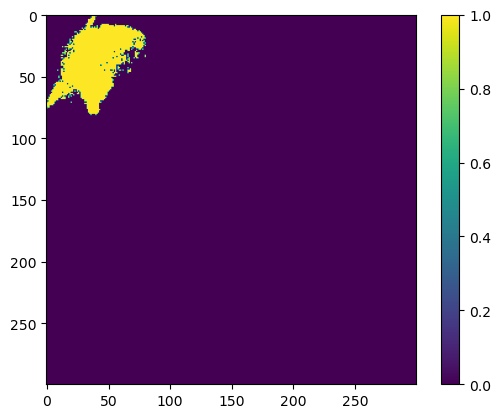

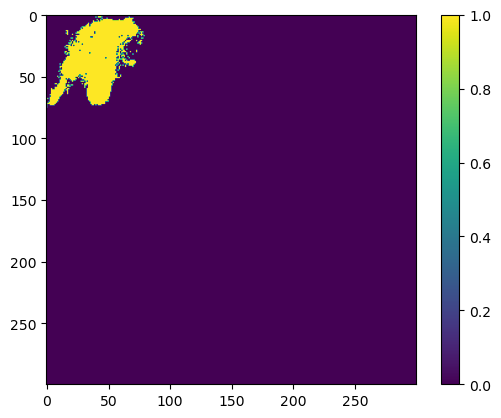

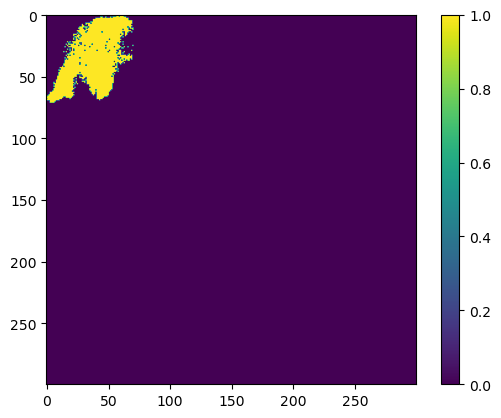

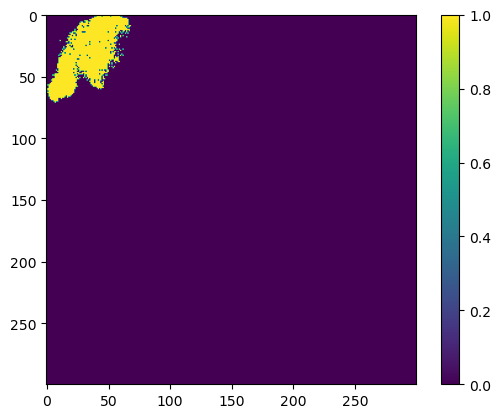

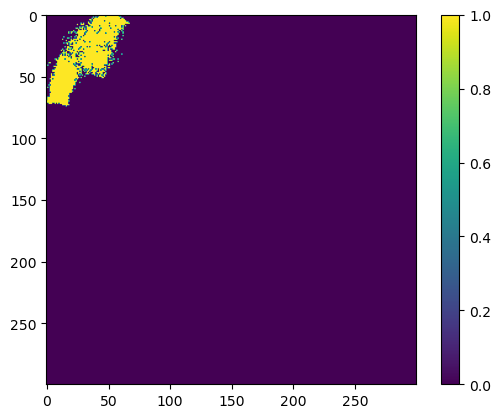

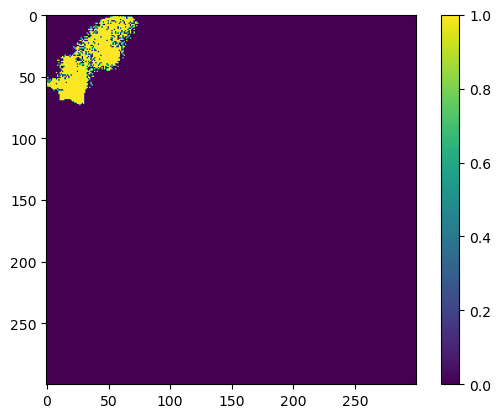

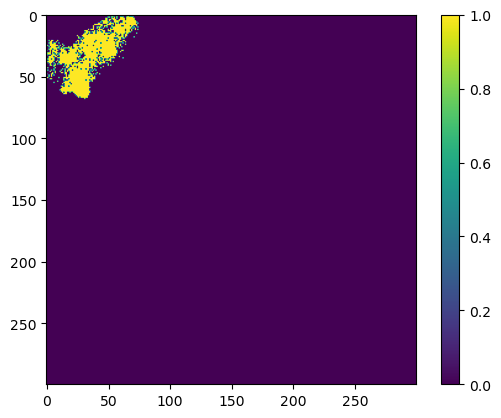

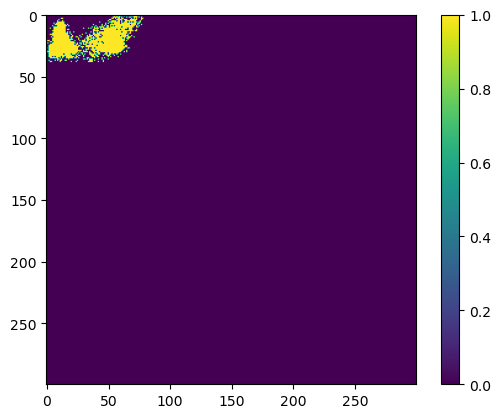

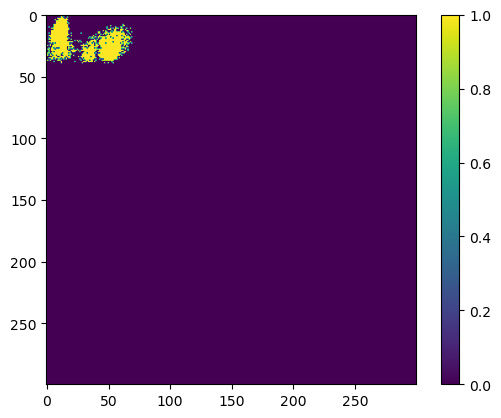

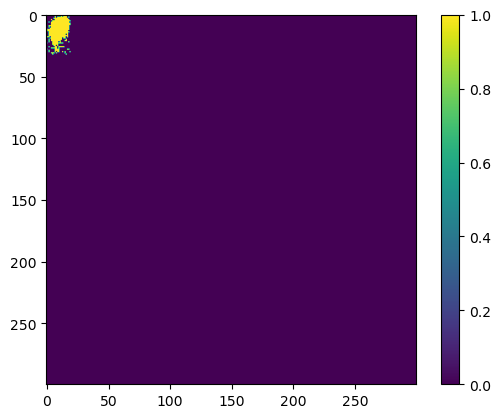

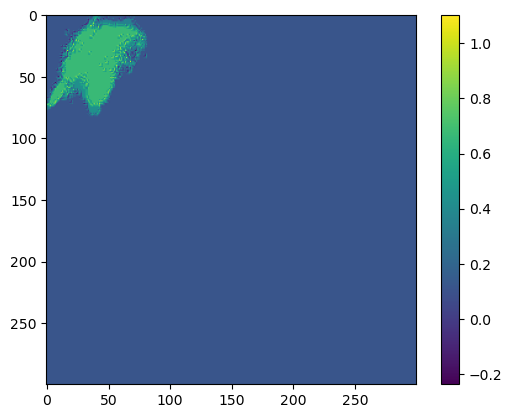

In [71]:
one_layer_cnn_model = model

for batch in dataloaders['test']:
    inputs, outputs = batch[0], batch[1]
    inputs, outputs = inputs.to(device), outputs.to(device)
    print(outputs.shape)
    pred = model(inputs[:, :sequence_length-1, :])
    print(pred.shape)

 

   
    

    for i in range(10):
        plt.imshow(outputs[0][0][i].detach().numpy(), cmap='viridis')
        plt.colorbar()
        plt.show()

       #prediction
    plt.imshow(pred[0][0][0].detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()
    # plt.imshow(outputs[:,-1,:][0][0].detach().numpy(), cmap='viridis')
    # plt.colorbar()
    # plt.show()


    # plt.imshow(outputs[:,-1,:][0][0].detach().numpy(), cmap='viridis')
    # plt.colorbar()
    # plt.show()
    break
    
    


In [ ]:
train_model()

Epoch: 0
training loss: 0.043971276256654944


/home/ines/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 10, 300, 300])) that is different to the input size (torch.Size([4, 1, 10, 300, 300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ines/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 10, 300, 300])) that is different to the input size (torch.Size([3, 1, 10, 300, 300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


validation loss: 0.047656142106279734
Epoch: 1
training loss: 0.041592788031058654
validation loss: 0.046913851099088785
Epoch: 2
training loss: 0.039290062045412404
validation loss: 0.04594824118539691
Epoch: 3
training loss: 0.037150403192000726
validation loss: 0.04503639978356659
Epoch: 4
training loss: 0.03518092547144209
validation loss: 0.04422360393218696
Epoch: 5
training loss: 0.03330327571768846
validation loss: 0.04335526507347822
Epoch: 6
training loss: 0.03162334261994277
validation loss: 0.043123579723760484
Epoch: 7
training loss: 0.02980793968641332
validation loss: 0.042422808986157176
Epoch: 8
training loss: 0.028291606317673412
validation loss: 0.042327256919816134
Epoch: 9
training loss: 0.026807537448725532
validation loss: 0.041655633877962825
Epoch: 10
training loss: 0.02545205642070089
validation loss: 0.04163234070874751
Epoch: 11
training loss: 0.02418131654017738
validation loss: 0.04117071414366365
Epoch: 12
training loss: 0.023008431906678846
validation lo